Process API

In [1]:
from sentinelhub import SHConfig

config = SHConfig()
#create an client and instance on sentinal-hub
config.sh_client_id = '1543b9e6-3abf-441b-9f19-0c8b70b925b2'
config.sh_client_secret = 'J2H.z_4ENpdQomb)Q1t*f-u?Zh<{)TH1Cd4JmQMv'
config.instance_id = "d6043a1f-543a-453e-acd6-8f90b6b74f56"
config.save()
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

C:\Users\Harith\anaconda3\envs\sentinal\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    Geometry,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image
from s2cloudless import CloudMaskRequest, S2PixelCloudDetector, get_s2_evalscript


Select Area

In [3]:
poly = [[7.090278,80.55444],[7.090278,80.55417],[7.090556,80.55222],[7.090278,80.55167],[7.09,80.55083],[7.091389,80.54806],[7.093056,80.55],[7.093333,80.55083],[7.094167,80.55306],[7.094167,80.55333],[7.093889,80.55417],[7.093611,80.555],[7.0925,80.55528],[7.091667,80.55528],[7.090833,80.555]]


In [4]:
#bounding box defining
def bbox_cord(poly):
    poly_arr = np.array(poly)
    df = pd.DataFrame(poly_arr, columns = ['long','lat'])
    Xmin = df['lat'].min()
    Ymin = df['long'].min()
    Xmax = df['lat'].max()
    Ymax = df['long'].max()
    bbox = [Xmin,Ymin,Xmax,Ymax]
    i = [1,0]
    output = poly_arr[:,i]
    output = output.tolist()
    return bbox,output
bbox_generated,poly = bbox_cord(poly)
bbox_generated

[80.54806, 7.09, 80.55528, 7.094167]

In [5]:
poly

[[80.55444, 7.090278],
 [80.55417, 7.090278],
 [80.55222, 7.090556],
 [80.55167, 7.090278],
 [80.55083, 7.09],
 [80.54806, 7.091389],
 [80.55, 7.093056],
 [80.55083, 7.093333],
 [80.55306, 7.094167],
 [80.55333, 7.094167],
 [80.55417, 7.093889],
 [80.555, 7.093611],
 [80.55528, 7.0925],
 [80.55528, 7.091667],
 [80.555, 7.090833]]

In [6]:
#define diementions for the request
final_bbox = BBox(bbox=bbox_generated, crs=CRS.WGS84)
geometry = Geometry(geometry={"type":"Polygon","coordinates":[poly]}, crs=CRS.WGS84)

In [7]:
#resolution and size of the output
resolution =10
box_size = bbox_to_dimensions(final_bbox, resolution= resolution)
print(f"Image shape at {resolution} m resolution: {box_size} pixels")

Image shape at 10 m resolution: (80, 46) pixels


In [8]:
#date range

current_date = datetime.today()
past_date = datetime.today() - relativedelta(months=12)
n_chunks = 4
tdelta = (current_date - past_date) / n_chunks
edges = [(past_date + i * tdelta).date().isoformat() for i in range(n_chunks+1)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2021-10-11', '2022-01-10')
('2022-01-10', '2022-04-12')
('2022-04-12', '2022-07-12')
('2022-07-12', '2022-10-11')


In [11]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04","B08","CLM"],
                units: "DN"
            }],
            output: {
                bands: 5,
                sampleType: "float32"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02, sample.B03, sample.B04,sample.B08,sample.CLM];
    }
"""
#32 bit Tiff output wuth 4 bands
def request_all_bands(time_interval):
    
    return  SentinelHubRequest(
        data_folder="Data", #data store directory
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
                #other_args={"dataFilter": {"maxCloudCoverage": 50}},
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=final_bbox,
        size=box_size,
        geometry = geometry,
        config=config,
    )

In [12]:
# create a list of requests
list_of_requests = [request_all_bands(slot) for slot in slots]
list_of_requests = [request.get_data() for request in list_of_requests]
list_of_requests

[[array([[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],
  
         [[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],
  
         [[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],
  
         ...,
  
         [[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],
  
         [[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0., 0

0 0 ('2021-10-11', '2022-01-10') (46, 80, 3)
1 0 ('2022-01-10', '2022-04-12') (46, 80, 3)
2 2558 ('2022-04-12', '2022-07-12') (46, 80, 3)
3 0 ('2022-07-12', '2022-10-11') (46, 80, 3)
0 3


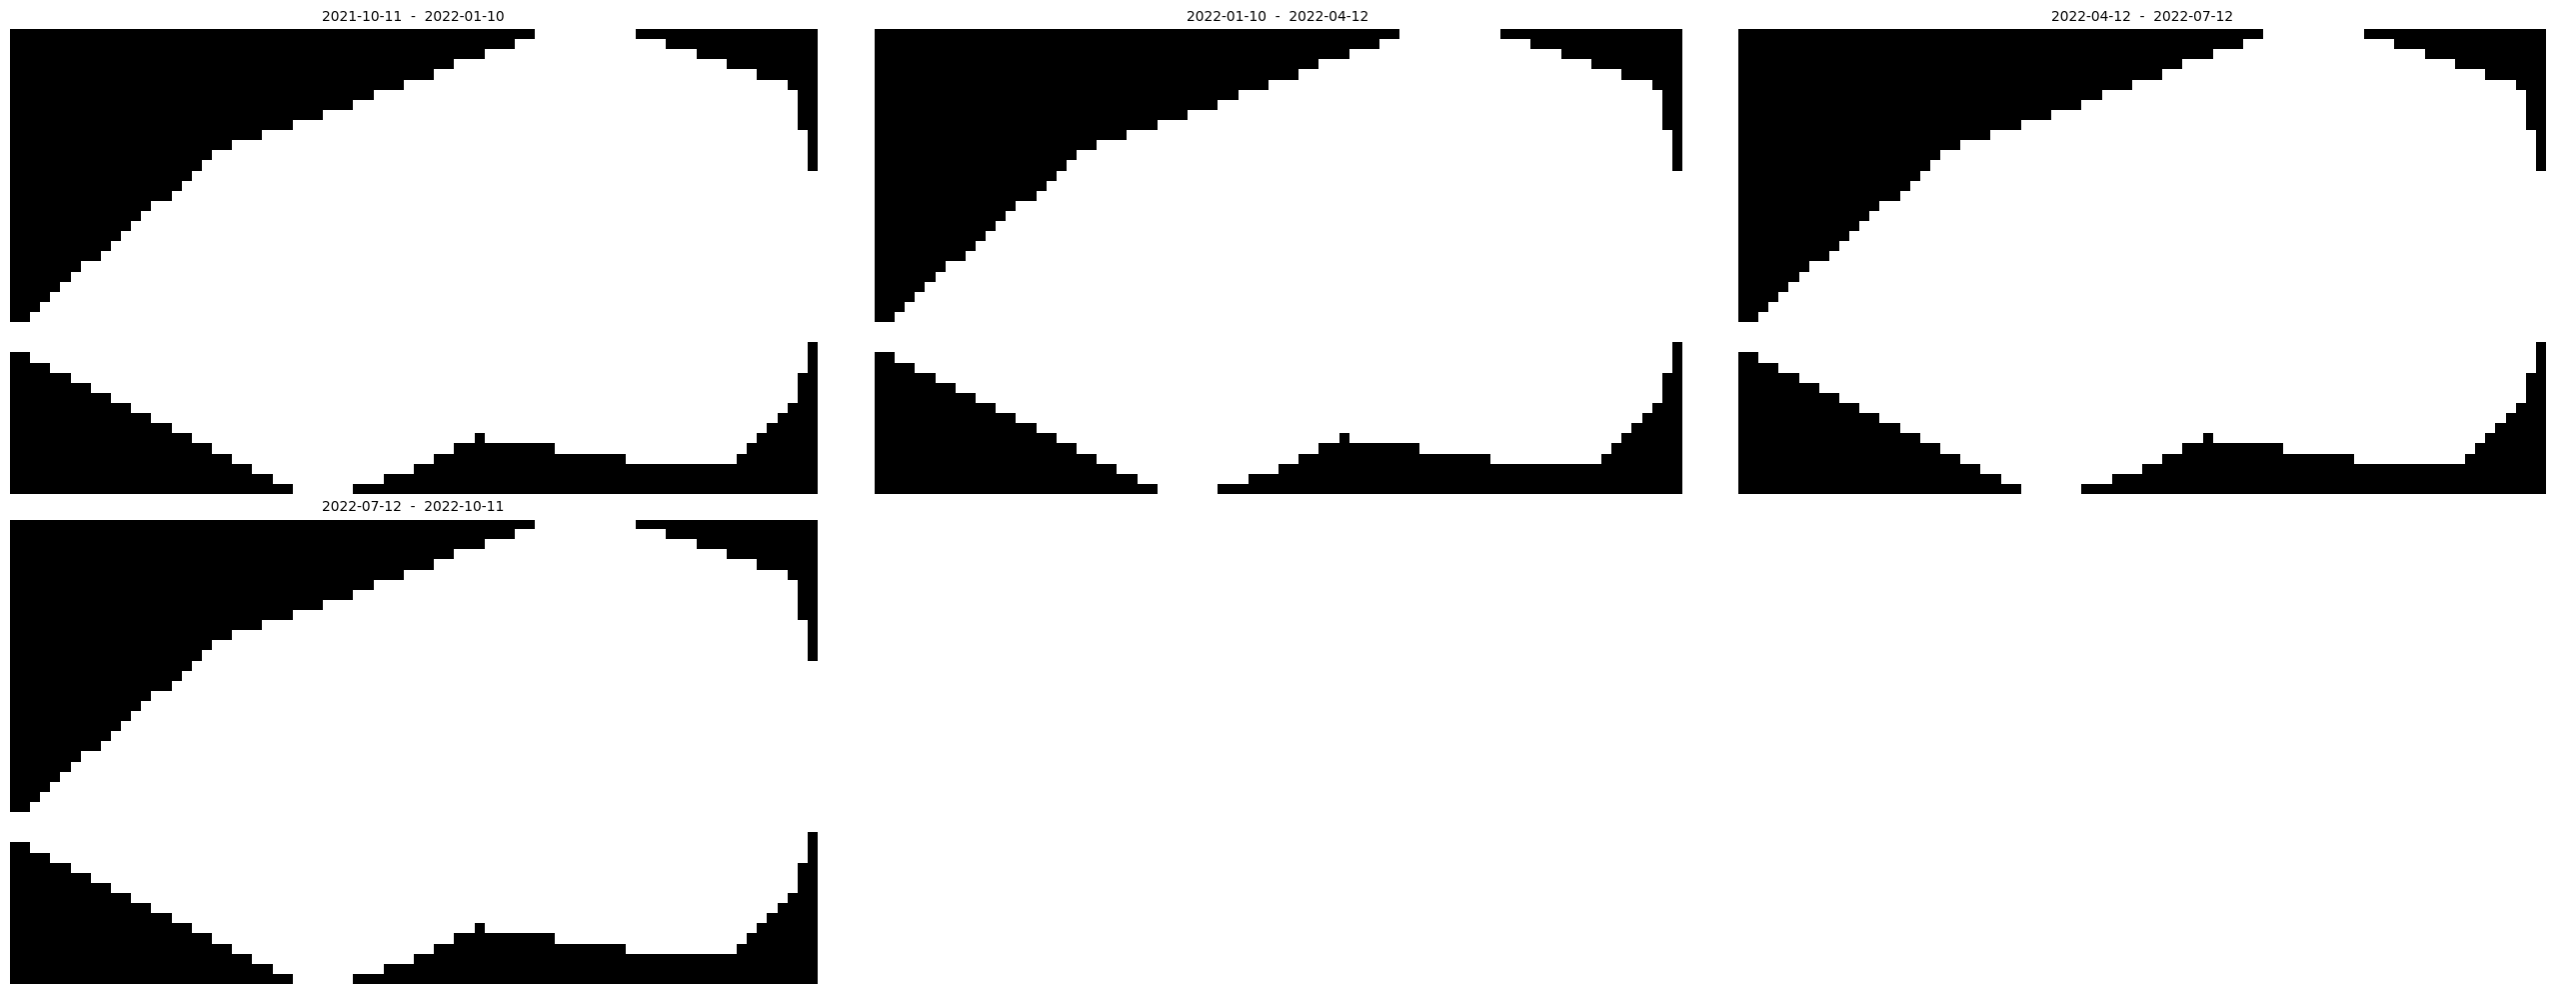

In [13]:
# plotting
cloud_pix=list_of_requests[0][0]
best=np.count_nonzero(cloud_pix == 1) #initializing
ncols = 3
nrows = 2
aspect_ratio = box_size[0] / box_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}
pos=0 #position
best_slot=0
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)
cloud_pix=list_of_requests[0][0]
best=np.count_nonzero(cloud_pix == 1)
for  idx, image in enumerate(list_of_requests):
    imagex = image[0][:, :, [0,1, 2]]
    cloud_pix = image[0][:, :, 4]
    cloud = np.count_nonzero(cloud_pix == 1)
    if best >= cloud :
        best=cloud
        best_slot=slots[idx]
        pos = idx
    print(idx,cloud,slots[idx],imagex.shape)
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(imagex * 2.5 , 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)
plt.tight_layout()
print(best,pos)

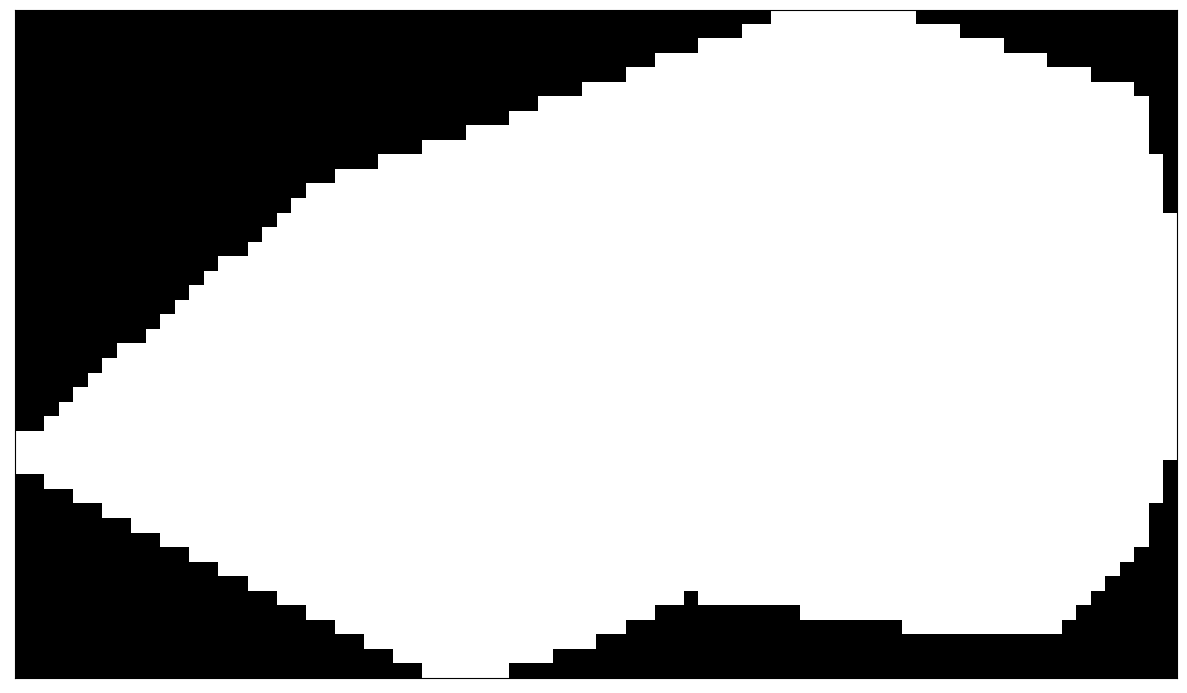

In [14]:
#plot best image
plot_image(list_of_requests[pos][0][:, :, [0, 1, 2]], factor=2.5, clip_range=(0, 1))

In [150]:
all_bands_img = request_all_bands(best_slot).get_data(save_data=True)